# Toxicity and Misoginy

In this jupyter notebook, we analyze how different subbredits and forums exhibited different levels of toxicity and misoginistic language, as measured by perspective API and a lexicon by [Farell et al 2019](https://github.com/miriamfs/WebSci2019/blob/master/Lexicon.txt).



In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import matplotlib.pyplot as plt
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np
import swifter
import json
import pandas as pd
import re

# Seaborn
import seaborn as sns
sns.set_style("ticks")

# Latex Configuration
import matplotlib.font_manager as font_manager
import matplotlib as mpl
import os
fontpath = os.path.expanduser('~/.local/share/fonts/LinLibertine_DRah.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 16,
    'axes.labelsize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': prop.get_name(),
    'text.usetex': True
}
mpl.rcParams.update(params)

# Local Modules
import os
import sys
sys.path.insert(0, os.path.abspath('/data/savvas/incels/manosphere_analysis/helpers/'))
from plot import set_size, plot_toxicity
from lexicon import hostility, flipping, sexual_violence, belitting, patriarchy, stoicism, count_words
categories_pretty = { 'mgtow': 'MGTOW', 'trp': 'TRP', 'pua': 'PUA', 'incels': 'Incels', 'mra': 'MRA'}

# Loads and preprocesses data

In [4]:
# load data from JSON files

JSON_DATA_BASE_DIR = '/data/savvas/incels/data/json/'
json_data_files = ['reddit.ndjson', 'incels.ndjson', 'rooshv.ndjson', 
                   'the_attraction.ndjson', 'pua_forum.ndjson',
                   'mgtow.ndjson', 'avfm.ndjson']
platform_names = ['Reddit', 'Incels.is', 'Rooshv', 'The Attraction', 
                  'MPUAForum', 'MGTOW Forum', 'AVFM']


In [ ]:

dfs = []

for i in range(len(json_data_files)):
    d = []
    with open(JSON_DATA_BASE_DIR + json_data_files[i], 'r') as f:
        for line in f:
            data = json.loads(line)
            d.append(data)
    dfs.append(pd.DataFrame(d))

In [ ]:
json_data_files = ['/control/4chan/4chan_random_sample.ndjson', 
                   '/control/reddit/random/reddit_random_comments.ndjson',
                   '/control/gab/gab_corpus2.ndjson']
platform_names = ['4chan', 'reddit', 'gab']

dfs_control = []

for i in range(len(json_data_files)):
    print(platform_names[i])
    d = []
    idy = 0
    with open(JSON_DATA_BASE_DIR + json_data_files[i], 'r') as f:
        for line in f:
            if idy % 1000000 == 0:
                print(idy)
            data = json.loads(line)
            if i == 0:
                if data["body"] == "N/A":
                    continue
                data = {"text_post": data["body"], "date_post": data["ts"], "id": data["id"]}

            if i == 1:
                data = {"text_post": data["body"], "date_post": int(data["created_utc"]), "id": data["id"]}
            if i == 2:
                data = {"text_post": data["content"], "date_post": data["created_at"], "id": data["id"]}
            d.append(data)
            idy+=1

    dfs_control.append(pd.DataFrame(d))
dfs_control[0]

In [ ]:
def map_or_none(id_post, mapping):
    try:
        a = mapping[id_post]
        return a
    except KeyError:
        return None
    
def load_mapping_into_df(df, mapping_file, mapping_json_keys, key_name_df):
    mapping = {}
    with open(mapping_file, 'r') as f:
        for line in f:
            data = json.loads(line)
            val = data
            for key in mapping_json_keys:
                val = val[key]
            mapping[data['id_post']] = val
            
    df[key_name_df] = df['id_post'].apply(map_or_none, args=(mapping,))
    return df

BASE_DIR_PERPSECTIVE = '/data/savvas/incels/data/json/perspective2/'
platform_names_raw = ['redditall', 'incels', 'rooshv', 'the_attraction', 'pua_forum',
                  'red_pill_talk', 'mgtow', 'avfm']
perspective_files = [BASE_DIR_PERPSECTIVE + 'perspective_severity_' + x +'_results.txt' for x in platform_names_raw]

i=0
for df in dfs:
    print(platform_names_raw[i])
    df = load_mapping_into_df(df, perspective_files[i], ['hate_output', 'SEVERE_TOXICITY'], 'perspective_toxicity')
    i+=1

In [ ]:
# perspective_severe4chan_random_sample_results.txt

BASE_DIR_PERSPECTIVE_CONTROL = "/data/savvas/incels/data/json/control/"

def load_mapping_into_df(df, mapping_file, mapping_json_keys, key_name_df):
    mapping = {}
    with open(mapping_file, 'r') as f:
        idy = 0
        for line in f:
            if idy % 1000000 == 0:
                print(idy)
            data = json.loads(line)
            val = data
            for key in mapping_json_keys:
                val = val[key]
            mapping[data['id_post']] = val
            idy += 1
        
            
    df[key_name_df] = df['id'].apply(map_or_none, args=(mapping,))
    return df

platform_names_raw = ['4chan', 'reddit', 'gab']
perspective_files = [
    BASE_DIR_PERSPECTIVE_CONTROL + '/4chan/perspective_severe4chan_random_sample_results.txt',
    BASE_DIR_PERSPECTIVE_CONTROL + "/reddit/random/perspective_severe_reddit_random_comments_results.txt",
    BASE_DIR_PERSPECTIVE_CONTROL + "/gab/perspective_severe_gab_corpus2_results.txt"
]

i=0
for df in dfs_control:
    print(platform_names_raw[i])
    df = load_mapping_into_df(df, perspective_files[i], ['hate_output', 'SEVERE_TOXICITY'], 'perspective_toxicity')
    i+=1

In [ ]:
for i in range(len(dfs)):
    df = dfs[i]
    if i==0:
        df['datetime'] = pd.to_datetime(df['date_post'], unit='s')
    else:
        df['datetime'] = pd.to_datetime(df['date_post'])
    i+=1
    
for i in range(len(dfs_control)):
    df = dfs_control[i]
    if i != 2:
        df['datetime'] = pd.to_datetime(df['date_post'], unit='s')
    else:
        df['datetime'] = pd.to_datetime(df['date_post'])
    i+=1

In [ ]:
# Removes health and criticism subreddits
to_remove = ["TheBluePill", "exredpill", "depression", "socialanxiety", "SuicideWatch", "IncelTears"]
for subreddit in to_remove:
    dfs[0] = dfs[0].loc[dfs[0].subreddit != subreddit]

In [ ]:
# Removes pre-2019
for i in range(len(dfs)):
    dfs[i] = dfs[i].loc[dfs[i]['datetime'].dt.year < 2019]

In [ ]:
def to_lowercase(s):
    return s.lower()

# do the same on the reddit dataset based on the categories
categoriesdf = pd.read_csv('/data/savvas/incels/subreddit_categories.txt')
categoriesdf = categoriesdf.loc[(categoriesdf.category != "criticism") & (categoriesdf.category != "health")]
redditdf = dfs[0]
redditdf['subreddit_lower'] = redditdf['subreddit'].map(to_lowercase)
categories_map = {}
for idx, row in categoriesdf.iterrows():
    categories_map[row['subreddits']] = row['category']
redditdf['subreddit_category'] = redditdf['subreddit_lower'].map(categories_map)  
categories = sorted((list(set(redditdf['subreddit_category'].tolist()))))
categories_pretty = { 'mgtow': 'MGTOW', 'trp': 'TRP', 'pua': 'PUA', 'incels': 'Incels', 'mra': 'MRA'}

# Counts lexicon occurrence on  dataframe

In [8]:
dfs[0]["lexicon_p"] = dfs[0].text_post.swifter.allow_dask_on_strings().apply(
    lambda x: count_words([hostility, flipping, sexual_violence, belitting, patriarchy, stoicism], x))

In [9]:
for df in dfs[1:]:
    print(len(df))
    df["lexicon_p"] = df.text_post.swifter.allow_dask_on_strings().apply(
    lambda x: count_words([hostility, flipping, sexual_violence, belitting, patriarchy, stoicism], x))

1770159



1433186



892199



888962



776073



210640


In [10]:
for df in dfs_control:
    print(len(df))
    df["lexicon_p"] = df.text_post.swifter.allow_dask_on_strings().apply(
    lambda x: count_words([hostility, flipping, sexual_violence, belitting, patriarchy, stoicism], x))

31656467



28000478



29724139


In [11]:
for df in dfs + dfs_control:
    df["hostility"] = df["lexicon_p"].swifter.apply(lambda x: x[0])
    df["flipping"] = df["lexicon_p"].swifter.apply(lambda x: x[1])
    df["sexual_violence"] = df["lexicon_p"].swifter.apply(lambda x: x[2])
    df["belitting"] = df["lexicon_p"].swifter.apply(lambda x: x[3])
    df["patriarchy"] = df["lexicon_p"].swifter.apply(lambda x: x[4])
    df["stoicism"] = df["lexicon_p"].swifter.apply(lambda x: x[5])
    df["lexicon"] = df["hostility"] + df["flipping"] +\
                    df["sexual_violence"] + df["belitting"] +\
                    df["patriarchy"] + df["stoicism"]    

# Saves Stuff

In [16]:
# Fixes reddit dataset column type
for col in ["author", "id_post", "subreddit", "text_post", "thread", "subreddit_lower", "subreddit_category"]:
    dfs[0][col] = dfs[0][col].astype(str)
dfs[0].date_post = dfs[0].date_post.astype(int)
dfs[0].datetime = pd.to_datetime(dfs[0].datetime)

print(0)
dfs[0].reset_index().to_feather("/data/savvas/incels/manosphere_analysis/helpers/dfs/df_{}".format(str(0)))

for idx, df in enumerate(dfs):
    if idx == 0:
        continue
    print(idx)
    df.reset_index().to_feather("/data/savvas/incels/manosphere_analysis/helpers/dfs/df_{}".format(str(idx)))

for idx, df in enumerate(dfs_control):
    print(idx)
    df.reset_index().to_feather("/data/savvas/incels/manosphere_analysis/helpers/dfs/df_{}_c".format(str(idx)))

0
1
2


#  (or) Loads Stuff

In [5]:
dfs = []
dfs_control = []

for idx in range(7):
    print(idx)
    dfs.append(
        pd.read_feather("/data/savvas/incels/manosphere_analysis/helpers/dfs/df_{}".format(str(idx)))
    )

for idx in range(3):
    print(idx)
    dfs_control.append(
        pd.read_feather("/data/savvas/incels/manosphere_analysis/helpers/dfs/df_{}_c".format(str(idx)))
    )
                      

0
1
2
3
4
5
6
0
1
2


In [6]:
redditdf = dfs[0]
categories = sorted((list(set(redditdf['subreddit_category'].tolist()))))

# Toxicity Plot

In [7]:
def get_toxicity(df, key, func):
        tmp = df.dropna(subset=[key]).groupby(pd.Grouper(key='datetime', freq='M'))[key].apply(
            lambda x: bs.bootstrap(x.values, func, num_iterations=1000)
        )

        point_estimate = tmp.apply(lambda x: x.value)
        low = tmp.apply(lambda x: x.lower_bound)
        high = tmp.apply(lambda x: x.upper_bound)

        return pd.DataFrame({"low": low, "high": high, "pe": point_estimate})

vals_t_reddit = []
vals_l_reddit = []
vals_t_forums = []
vals_l_forums = []
vals_t_control = []
vals_l_control = []

for cat in categories:
    print(cat)
    df = redditdf.loc[redditdf.subreddit_category == cat]
    vals_l_reddit.append(get_toxicity(df, "lexicon", bs_stats.mean))
    vals_t_reddit.append(get_toxicity(df, "perspective_toxicity", bs_stats.mean))
                         
for df in dfs[1:]:
    print(len(df))
    vals_l_forums.append(get_toxicity(df, "lexicon", bs_stats.mean))
    vals_t_forums.append(get_toxicity(df, "perspective_toxicity", bs_stats.mean))
            
for df in dfs_control[1:2]:
    print(len(df))
    vals_l_control.append(get_toxicity(df, "lexicon", bs_stats.mean))
    vals_t_control.append(get_toxicity(df, "perspective_toxicity", bs_stats.mean))

incels
mgtow


/home/manoel/miniconda3/envs/manosphere/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:447: RuntimeWarning: Mean of empty slice.
  return N.ndarray.mean(self, axis, dtype, out, keepdims=True)._collapse(axis)
/home/manoel/miniconda3/envs/manosphere/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


mra
pua
trp
1770159
1433186
892199
888962
776073
210640
28000478


In [8]:
# fixes max reddit date
flag = vals_t_control[0].index < pd.to_datetime("2019-01-01")
vals_t_control[0] = vals_t_control[0][flag]
flag = vals_l_control[0].index < pd.to_datetime("2019-01-01")
vals_l_control[0] = vals_l_control[0][flag]

In [9]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


chan_toxicity = mean_confidence_interval(dfs_control[0].dropna()["perspective_toxicity"].values)
gab_toxicity = mean_confidence_interval(dfs_control[2].dropna()["perspective_toxicity"].values)
chan_lexicon = mean_confidence_interval(dfs_control[0].dropna()["lexicon"].values)
gab_lexicon = mean_confidence_interval(dfs_control[2].dropna()["lexicon"].values)

In [11]:
colors_f = ["#000000", "#171515", "#0b431c", "#559b5b", "#1e6b4d", "#864f0d", "#762a83"]
ls_f = ["-", "-", "-", ":", "-.", "-", "-", "-"]
colors_c = ["#171515", "#864f0d", "#762a83", "#559b5b", "#e08214"]
ls_c = ["-", "-", ":", "--", "-."]

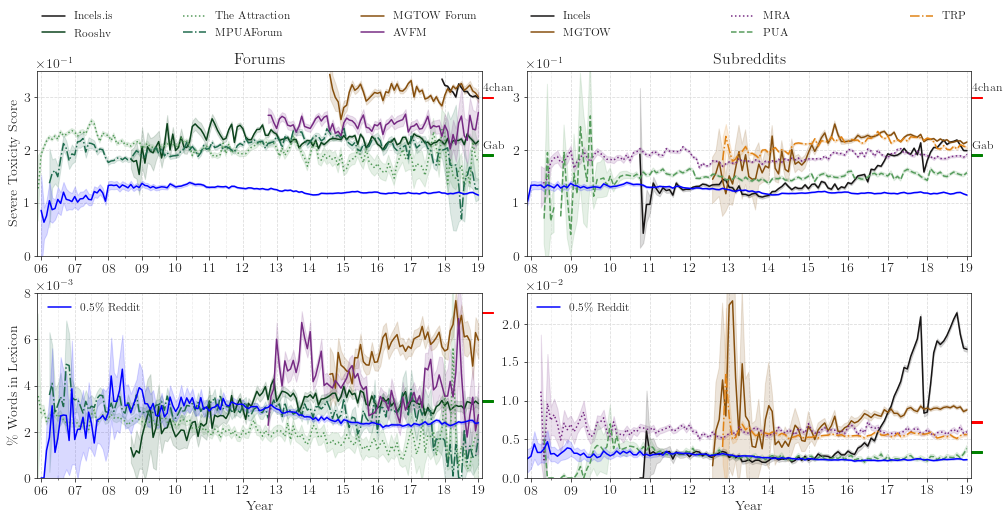

In [23]:
import matplotlib.transforms as transforms
import matplotlib.patches as mpatches


def plot_hline(ax, val, text, color):
    y1, y2  =ax.get_ylim()
    trans = transforms.blended_transform_factory(
        ax.transAxes, ax.transData)
    
    rect = mpatches.Rectangle((1, val[1]), width=.025, height=(y2-y1)/100,
                         transform=trans, color=color, clip_on=False)
    ax.add_patch(rect)
    
    if text is not False:
        ax.text(1.001, val[2] + 0.0125, text, 
                         transform=trans, ha='left', size=12)

    
fig, axs_all = plt.subplots(2, 2, figsize=(14, 7.25), gridspec_kw={"wspace": 0.1}, sharey=False)

axs = axs_all[0, :]

plot_toxicity(vals_t_forums, colors_f[1:], ls_f[1:], forums=True, legend=True, 
              leg=['Incels.is', 'Rooshv', 'The Attraction', 
                  'MPUAForum', 'MGTOW Forum', 'AVFM'], ncols=3, ax=axs[0])

plot_toxicity(vals_t_reddit, colors_c, ls_c, forums=False, legend=True, 
              leg=[categories_pretty[x] for x in categories], ncols=3,
             ax=axs[1])

plot_toxicity([vals_t_control[0]], ["blue"], ls_c[1:], forums=True, legend=False, 
              leg=["reddit"], ncols=3, ax=axs[0])

plot_toxicity([vals_t_control[0]], ["blue"], ls_c[1:], forums=False, legend=False, 
              leg=["reddit"], ncols=3, ax=axs[1])


axs[0].set_ylabel("Severe Toxicity Score")
axs[0].set_title("Forums")
axs[1].set_title("Subreddits")
axs[1].set_ylim(0, 0.35)
axs[0].set_ylim(0, 0.35)
plot_hline(axs[0], gab_toxicity, "Gab", color="green")
plot_hline(axs[1], gab_toxicity, "Gab", color="green")
plot_hline(axs[0], chan_toxicity, "4chan", color="red")
plot_hline(axs[1], chan_toxicity, "4chan", color="red")


axs = axs_all[1, :]

plot_toxicity(vals_l_forums, colors_f[1:], ls_f[1:], forums=True, legend=False, 
              leg=['Incels.is', 'Rooshv', 'The Attraction', 
                  'MPUAForum', 'MGTOW Forum', 'AVFM'], ncols=3, ax=axs[0])

plot_toxicity(vals_l_reddit, colors_c, ls_c, forums=False, legend=False, 
              leg=[categories_pretty[x] for x in categories], ncols=3,
             ax=axs[1])

plot_toxicity([vals_l_control[0]], ["blue"], ls_c[1:], forums=True, legend=False, inner_legend=True,
              leg=["0.5\% Reddit"], ncols=3, ax=axs[0])

plot_toxicity([vals_l_control[0]], ["blue"], ls_c[1:], forums=False, legend=False, inner_legend=True,
          leg=["0.5\% Reddit"], ncols=3, ax=axs[1])

axs[0].set_ylabel("\% Words in Lexicon")
axs[1].set_ylim(0, 0.024)
axs[0].set_ylim(0, 0.008)
plot_hline(axs[0], gab_lexicon, text=False, color="green")
plot_hline(axs[1], gab_lexicon, text=False, color="green")
plot_hline(axs[0], chan_lexicon, text=False, color="red")
plot_hline(axs[1], chan_lexicon,text=False, color="red")

axs[0].set_xlabel("Year")
axs[1].set_xlabel("Year")
set_size(fig, (14, 7.25))

fig.savefig('/data/savvas/incels/manosphere_analysis/images/all_toxicity.pdf', bbox_inches='tight')

In [55]:
chan_lexicon[2] - chan_lexicon[0]

1.38260829719997e-05

In [30]:
def get_toxicity(df, key, func):
        tmp = df.dropna(subset=[key]).groupby(pd.Grouper(key='datetime', freq='M'))[key].apply(
            lambda x: bs.bootstrap(x.values, func, num_iterations=10)
        )

        point_estimate = tmp.apply(lambda x: x.value)
        low = tmp.apply(lambda x: x.lower_bound)
        high = tmp.apply(lambda x: x.upper_bound)

        return pd.DataFrame({"low": low, "high": high, "pe": point_estimate})

In [31]:
four_chan_lex = get_toxicity(dfs_control[0], "lexicon", bs_stats.mean)

In [32]:
four_chan_per = get_toxicity(dfs_control[0], "perspective_toxicity", bs_stats.mean)

In [62]:
gab_lex = get_toxicity(dfs_control[2], "lexicon", bs_stats.mean)

In [58]:
gab_per = get_toxicity(dfs_control[2], "perspective_toxicity", bs_stats.mean)

In [63]:
min(gab_lex.pe)

0.0024056205969197305

In [64]:
max(gab_lex.pe)

0.0036770550627540505

In [ ]:
chan_lexicon[0] - chan_lexicon[1]